# Install and setup

The first block have to be executed twice to fully install the neccessary modules

In [2]:
!pip install datasets transformers evaluate
!python -m spacy download en_core_web_sm
!pip install torchtext==0.6.0
!pip install pyvi
!pip install dill
!pip install https://gitlab.com/trungtv/vi_spacy/-/raw/master/vi_core_news_lg/dist/vi_core_news_lg-0.0.1.tar.gz

DEPRECATION: https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0-py3-none-any.whl#egg=en_core_web_sm==3.0.0 contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 84.7 MB/s eta 0:00:0000:0100:01
  Using cached typer-0.3.2-py3-none-any.whl.metadata (12 kB)
Using cached typer-0.3.2-py3-none-any.whl (21 kB)
  Attempting uninstall: typer
    Found existing installation: typer 0.13.1
    Uninstalling typer-0.13.1:
      Successfully uninstalled typer-0.13.1
  Attempting uninstall: en-core-web-sm
    Found existing installation: en_core_web_sm 3.8.0
    Uninstalling en_core_web_sm-3.8.0:
      Successfully uninstalled en_core_web_sm-3.8.0
ERROR: pip's dependency resolver does not currently take in

# Import


In [3]:
import torchtext
print(torchtext.__version__)

0.6.0


In [4]:
import torch
from torch import nn, optim
from torch.optim import Adam
import torch.utils.data as data
import math
from collections import Counter
import numpy as np
import copy
import time
import spacy
import re
from torchtext import data
import pandas as pd
from torch.autograd import Variable
import dill as pickle
import spacy
import torch.nn.functional as F
from torchtext.data.metrics import bleu_score
import os
import nltk
from tqdm import tqdm_notebook as tqdm

In [5]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [7]:
from nltk.corpus import wordnet

# Download dataset

In [8]:
import datasets

dataset = datasets.load_dataset("harouzie/vi_en-translation")

README.md:   0%|          | 0.00/665 [00:00<?, ?B/s]

(…)-00000-of-00001-8fc21cb8e80d3a2d.parquet:   0%|          | 0.00/11.3M [00:00<?, ?B/s]

(…)-00000-of-00001-858c0e989d9c5637.parquet:   0%|          | 0.00/1.42M [00:00<?, ?B/s]

(…)-00000-of-00001-99e7e50144d1c164.parquet:   0%|          | 0.00/1.42M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/203272 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25409 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/25409 [00:00<?, ? examples/s]

In [9]:
train_data, test_data, valid_data = (dataset['train'], dataset['test'], dataset['valid'])

# The model

In [10]:
class Embedder(nn.Module):
  def __init__(self, vocab_size, model_dim):
    super(Embedder, self).__init__()
    self.vocab_size = vocab_size
    self.model = model_dim

    self.embed = nn.Embedding(vocab_size, model_dim)

  def forward(self, x):
    return self.embed(x)

Embedder(100, 512)(torch.LongTensor([1,2,3,4])).shape


torch.Size([4, 512])

In [11]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_length=200, dropout=0.1):
        super().__init__()

        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(max_seq_length, d_model)

        for pos in range(max_seq_length):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos/(10000**(2*i/d_model)))
                pe[pos, i+1] = math.cos(pos/(10000**((2*i+1)/d_model)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):

      x = x*math.sqrt(self.d_model)
      seq_length = x.size(1)

      pe = Variable(self.pe[:, :seq_length], requires_grad=False)

      if x.is_cuda:
          pe.cuda()
      x = x + pe
      x = self.dropout(x)

      return x

PositionalEncoder(512)(torch.rand(5, 30, 512)).shape

torch.Size([5, 30, 512])

In [12]:
def attention(q, k, v, mask=None, dropout=None):
    """Compute the attention scores and output.

    Args:
        q (torch.Tensor): Query tensor of shape (batch_size, num_heads, seq_length, d_k).
        k (torch.Tensor): Key tensor of shape (batch_size, num_heads, seq_length, d_k).
        v (torch.Tensor): Value tensor of shape (batch_size, num_heads, seq_length, d_v).
        mask (torch.Tensor, optional): Mask tensor to prevent attention to certain positions. 
                                       Shape should be (batch_size, 1, seq_length) or 
                                       (batch_size, num_heads, seq_length). Defaults to None.
        dropout (torch.nn.Module, optional): Dropout layer to apply to the attention scores. 
                                              Defaults to None.

    Returns:
        torch.Tensor: The output tensor after applying attention, shape (batch_size, num_heads, seq_length, d_v).
        torch.Tensor: The attention scores, shape (batch_size, num_heads, seq_length, seq_length).
    """
    d_k = q.size(-1)
    scores = torch.matmul(q, k.transpose(-2, -1))/math.sqrt(d_k)

    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask==0, -1e9)
    scores = F.softmax(scores, dim=-1)

    if dropout is not None:
        scores = dropout(scores)

    output = torch.matmul(scores, v)
    return output, scores

In [13]:
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention mechanism as described in the "Attention is All You Need" paper.

    This class implements the multi-head attention mechanism, which allows the model to jointly 
    attend to information from different representation subspaces at different positions. 
    It consists of multiple attention heads that compute attention scores and outputs in parallel.

    Attributes:
        d_model (int): The dimensionality of the input and output embeddings.
        d_k (int): The dimensionality of the key vectors (d_model / heads).
        h (int): The number of attention heads.
        attn (torch.Tensor): The attention scores from the last forward pass.
        q_linear (nn.Linear): Linear transformation for the query vectors.
        k_linear (nn.Linear): Linear transformation for the key vectors.
        v_linear (nn.Linear): Linear transformation for the value vectors.
        dropout (nn.Dropout): Dropout layer applied to the attention scores.
        out (nn.Linear): Linear transformation applied to the concatenated output of all heads.

    Methods:
        forward(q, k, v, mask=None):
            Computes the multi-head attention output and attention scores.

    Args:
        heads (int): The number of attention heads.
        d_model (int): The dimensionality of the input and output embeddings.
        dropout (float, optional): The dropout rate for the attention scores. Default is 0.1.
    """
    def __init__(self, heads, d_model, dropout=0.1):
        super().__init__()
        assert d_model % heads == 0

        self.d_model = d_model
        self.d_k = d_model//heads
        self.h = heads
        self.attn = None

        # tạo ra 3 ma trận trọng số là q_linear, k_linear, v_linear
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        """
        q: [batch_size, seq_length, d_model]
        k: [batch_size, seq_length, d_model]
        v: [batch_size, seq_length, d_model]
        mask: [batch_size, 1, seq_length]
        output: [batch_size, seq_length, d_model]
        """
        bs = q.size(0)

        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)

        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        scores, self.attn = attention(q, k, v, mask, self.dropout)

        concat = scores.transpose(1, 2).contiguous().view(bs, -1, self.d_model)

        output = self.out(concat)
        return output



In [14]:
class Norm(nn.Module):
    """
    Layer normalization class.

    This class implements layer normalization, which normalizes the input across the features dimension.
    
    Attributes:
        size (int): The dimensionality of the input.
        alpha (nn.Parameter): Learnable scale parameter.
        bias (nn.Parameter): Learnable bias parameter.
        eps (float): A small value to avoid division by zero during normalization.

    Args:
        d_model (int): The dimensionality of the input.
        eps (float, optional): A small value to avoid division by zero. Default is 1e-6.
    """
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()

        self.size = d_model

        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))

        self.eps = eps

    def forward(self, x):
        """
        Forward pass for layer normalization.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, ..., d_model).

        Returns:
            torch.Tensor: Normalized output tensor.
        """
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

class FeedForward(nn.Module):
    """
    Feedforward neural network class.

    This class implements a feedforward neural network with two linear transformations and a ReLU activation function.
    
    Attributes:
        linear_1 (nn.Linear): First linear transformation.
        dropout (nn.Dropout): Dropout layer applied after the first linear transformation.
        linear_2 (nn.Linear): Second linear transformation.

    Args:
        d_model (int): The dimensionality of the input.
        d_ff (int, optional): The dimensionality of the hidden layer. Default is 2048.
        dropout (float, optional): Dropout rate. Default is 0.1.
    """
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__()

        # set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        """
        Forward pass for the feedforward network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length, d_model).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, seq_length, d_model).
        """
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

In [15]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, mask):

        x2 = self.norm_1(x)
        # calculate attention value
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x

In [16]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)

        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)

        self.attn_1 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.attn_2 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)

    def forward(self, x, e_outputs, src_mask, trg_mask):
        """
        x: [batch_siz, seq_length, d_model]
        e_outputs: [batch_siz, seq_length, d_model]
        src_mask: [batch_size, 1, seq_length]
        trg_mask: [batch_size, 1, seq_length]
        """
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)

        x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs, src_mask))
        x2 = self.norm_3(x)
        x = x + self.dropout_3(self.ff(x2))
        return x

In [17]:
import copy

def get_clones(module, N):
    """
    Create N identical clones of a given module.

    Args:
        module (nn.Module): The module to clone.
        N (int): The number of clones to create.

    Returns:
        nn.ModuleList: A list containing N deep copies of the input module.
    """
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class Encoder(nn.Module):
    """
    Encoder class for the Transformer model.

    This class implements the encoder part of the Transformer architecture, which processes the input sequence
    and generates a sequence of continuous representations.

    Attributes:
        N (int): The number of encoder layers.
        embed (Embedder): The embedding layer for input tokens.
        pe (PositionalEncoder): The positional encoding layer to add positional information to the embeddings.
        layers (nn.ModuleList): A list of encoder layers.
        norm (Norm): Layer normalization applied to the output of the encoder.

    Args:
        vocab_size (int): The size of the vocabulary.
        d_model (int): The dimensionality of the model (embedding size).
        N (int): The number of encoder layers.
        heads (int): The number of attention heads.
        dropout (float): The dropout rate for regularization.

    Methods:
        forward(src, mask):
            Processes the input sequence and returns the encoded representations.

    Args:
        src (torch.Tensor): Input tensor of shape (batch_size, seq_length).
        mask (torch.Tensor): Mask tensor of shape (batch_size, 1, seq_length) to prevent attention to certain positions.

    Returns:
        torch.Tensor: The output tensor of shape (batch_size, seq_length, d_model) after processing through the encoder.
    """
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(EncoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)

    def forward(self, src, mask):
        """
        Forward pass for the encoder.

        Args:
            src (torch.Tensor): Input tensor of shape (batch_size, seq_length).
            mask (torch.Tensor): Mask tensor of shape (batch_size, 1, seq_length).

        Returns:
            torch.Tensor: The output tensor of shape (batch_size, seq_length, d_model).
        """
        x = self.embed(src)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, mask)
        return self.norm(x)

class Decoder(nn.Module):
    """
    Decoder class for the Transformer model.

    This class implements the decoder part of the Transformer architecture, which generates the output sequence
    based on the encoded representations and the previous output tokens.

    Attributes:
        N (int): The number of decoder layers.
        embed (Embedder): The embedding layer for target tokens.
        pe (PositionalEncoder): The positional encoding layer to add positional information to the embeddings.
        layers (nn.ModuleList): A list of decoder layers.
        norm (Norm): Layer normalization applied to the output of the decoder.

    Args:
        vocab_size (int): The size of the vocabulary.
        d_model (int): The dimensionality of the model (embedding size).
        N (int): The number of decoder layers.
        heads (int): The number of attention heads.
        dropout (float): The dropout rate for regularization.

    Methods:
        forward(trg, e_outputs, src_mask, trg_mask):
            Processes the target sequence and returns the decoded output.

    Args:
        trg (torch.Tensor): Target tensor of shape (batch_size, seq_length).
        e_outputs (torch.Tensor): Encoded outputs from the encoder of shape (batch_size, seq_length, d_model).
        src_mask (torch.Tensor): Mask tensor for the source input of shape (batch_size, 1, seq_length).
        trg_mask (torch.Tensor): Mask tensor for the target input of shape (batch_size, 1, seq_length).

    Returns:
        torch.Tensor: The output tensor of shape (batch_size, seq_length, d_model) after processing through the decoder.
    """
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(DecoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)

    def forward(self, trg, e_outputs, src_mask, trg_mask):
        """
        Forward pass for the decoder.

        Args:
            trg (torch.Tensor): Target tensor of shape (batch_size, seq_length).
            e_outputs (torch.Tensor): Encoded outputs from the encoder of shape (batch_size, seq_length, d_model).
            src_mask (torch.Tensor): Mask tensor for the source input of shape (batch_size, 1, seq_length).
            trg_mask (torch.Tensor): Mask tensor for the target input of shape (batch_size, 1, seq_length).

        Returns:
            torch.Tensor: The output tensor of shape (batch_size, seq_length, d_model).
        """
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)

In [18]:
class Transformer(nn.Module):
    """
    Transformer model for sequence-to-sequence tasks.

    This class implements the Transformer architecture as described in the "Attention is All You Need" paper.
    It consists of an encoder and a decoder, which are used to process input sequences and generate output sequences.

    Attributes:
        encoder (Encoder): The encoder component of the Transformer, which processes the input sequence.
        decoder (Decoder): The decoder component of the Transformer, which generates the output sequence based on the encoded representations.
        out (nn.Linear): A linear layer that maps the decoder output to the target vocabulary size.

    Args:
        src_vocab (int): The size of the source vocabulary.
        trg_vocab (int): The size of the target vocabulary.
        d_model (int): The dimensionality of the model (embedding size).
        N (int): The number of layers in both the encoder and decoder.
        heads (int): The number of attention heads in the multi-head attention mechanism.
        dropout (float): The dropout rate for regularization.

    Methods:
        forward(src, trg, src_mask, trg_mask):
            Processes the input and target sequences through the encoder and decoder, returning the output tensor.

    Args for forward method:
        src (torch.Tensor): Input tensor of shape (batch_size, seq_length) representing the source sequence.
        trg (torch.Tensor): Target tensor of shape (batch_size, seq_length) representing the target sequence.
        src_mask (torch.Tensor): Mask tensor of shape (batch_size, 1, seq_length) to prevent attention to certain positions in the source sequence.
        trg_mask (torch.Tensor): Mask tensor of shape (batch_size, 1, seq_length) to prevent attention to certain positions in the target sequence.

    Returns:
        torch.Tensor: The output tensor of shape (batch_size, seq_length, trg_vocab) after processing through the encoder and decoder.
    """
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads, dropout):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads, dropout)
        self.decoder = Decoder(trg_vocab, d_model, N, heads, dropout)
        self.out = nn.Linear(d_model, trg_vocab)
    def forward(self, src, trg, src_mask, trg_mask):
        """
        src: [batch_size, seq_length]
        trg: [batch_size, seq_length]
        src_mask: [batch_size, 1, seq_length]
        trg_mask: [batch_size, 1, seq_length]
        output: [batch_size, seq_length, d_model]
        """
        e_outputs = self.encoder(src, src_mask)

        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output

# Data processing and intialize data loader


In [19]:
class MyIterator(data.Iterator):
    """
    Custom iterator class for batching data in a training or evaluation loop.

    This class extends the `data.Iterator` to create batches of data for training or evaluation.
    It supports shuffling and sorting of batches based on a specified key.

    Methods:
        create_batches(): Creates batches of data for training or evaluation.
    """
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)

        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))


global max_src_in_batch, max_tgt_in_batch

def batch_size_fn(new, count, sofar):
    """
    Function to determine the batch size based on the maximum source and target lengths.

    Args:
        new: The new data instance being added to the batch.
        count: The current count of instances in the batch.
        sofar: The current size of the batch.

    Returns:
        int: The size of the batch based on the maximum source and target lengths.
    """
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)


def nopeak_mask(size, device):
    """
    Creates a mask to prevent attention to future tokens in the sequence.

    Args:
        size (int): The size of the sequence.
        device (torch.device): The device to which the mask will be moved.

    Returns:
        torch.Tensor: A mask tensor of shape (1, size, size) with upper triangular values set to 0.
    """
    np_mask = np.triu(np.ones((1, size, size)),
    k=1).astype('uint8')
    np_mask =  Variable(torch.from_numpy(np_mask) == 0)
    np_mask = np_mask.to(device)

    return np_mask

def create_masks(src, trg, src_pad, trg_pad, device):
    """
    Creates source and target masks for the attention mechanism.

    Args:
        src (torch.Tensor): The source input tensor.
        trg (torch.Tensor): The target input tensor.
        src_pad (int): The padding index for the source.
        trg_pad (int): The padding index for the target.
        device (torch.device): The device to which the masks will be moved.

    Returns:
        tuple: A tuple containing the source mask and the target mask.
    """
    src_mask = (src != src_pad).unsqueeze(-2)

    if trg is not None:
        trg_mask = (trg != trg_pad).unsqueeze(-2)
        size = trg.size(1) # get seq_len for matrix
        np_mask = nopeak_mask(size, device)
        if trg.is_cuda:
            np_mask.cuda()
        trg_mask = trg_mask & np_mask

    else:
        trg_mask = None
    return src_mask, trg_mask


def get_synonym(word, SRC):
    """
    Retrieves a synonym for a given word from the WordNet corpus.

    Args:
        word (str): The word for which to find a synonym.
        SRC: The source vocabulary object.

    Returns:
        int: The index of the synonym in the vocabulary, or 0 if no synonym is found.
    """
    syns = wordnet.synsets(word)
    for s in syns:
        for l in s.lemmas():
            if SRC.vocab.stoi[l.name()] != 0:
                return SRC.vocab.stoi[l.name()]

    return 0


def multiple_replace(dict, text):
    """
    Replaces multiple substrings in a given text based on a dictionary mapping.

    Args:
        dict (dict): A dictionary where keys are substrings to be replaced and values are their replacements.
        text (str): The input text in which to perform replacements.

    Returns:
        str: The modified text with replacements made.
    """
    regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

    return regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], text)


def init_vars(src, model, SRC, TRG, device, k, max_len):
    """
    Initializes variables for the beam search process.

    Args:
        src (torch.Tensor): The source input tensor.
        model: The transformer model.
        SRC: The source vocabulary object.
        TRG: The target vocabulary object.
        device (torch.device): The device to which the tensors will be moved.
        k (int): The number of beams for beam search.
        max_len (int): The maximum length of the output sequence.

    Returns:
        tuple: A tuple containing the initialized outputs, encoder outputs, and log scores.
    """
    init_tok = TRG.vocab.stoi['<sos>']
    src_mask = (src != SRC.vocab.stoi['<pad>']).unsqueeze(-2)

    e_output = model.encoder(src, src_mask)

    outputs = torch.LongTensor([[init_tok]])

    outputs = outputs.to(device)

    trg_mask = nopeak_mask(1, device)
    out = model.out(model.decoder(outputs,
    e_output, src_mask, trg_mask))
    out = F.softmax(out, dim=-1)

    probs, ix = out[:, -1].data.topk(k)
    log_scores = torch.Tensor([math.log(prob) for prob in probs.data[0]]).unsqueeze(0)

    outputs = torch.zeros(k, max_len).long()
    outputs = outputs.to(device)
    outputs[:, 0] = init_tok
    outputs[:, 1] = ix[0]

    e_outputs = torch.zeros(k, e_output.size(-2),e_output.size(-1))

    e_outputs = e_outputs.to(device)
    e_outputs[:, :] = e_output[0]

    return outputs, e_outputs, log_scores

def k_best_outputs(outputs, out, log_scores, i, k):
    """
    Selects the k best outputs from the current predictions.

    Args:
        outputs (torch.Tensor): The current output tensor.
        out (torch.Tensor): The output tensor from the model.
        log_scores (torch.Tensor): The log scores of the current outputs.
        i (int): The current index in the output sequence.
        k (int): The number of best outputs to select.

    Returns:
        tuple: A tuple containing the updated outputs and log scores.
    """
    probs, ix = out[:, -1].data.topk(k)
    log_probs = torch.Tensor([math.log(p) for p in probs.data.view(-1)]).view(k, -1) + log_scores.transpose(0,1)
    k_probs, k_ix = log_probs.view(-1).topk(k)

    row = k_ix // k
    col = k_ix % k

    outputs[:, :i] = outputs[row, :i]
    outputs[:, i] = ix[row, col]

    log_scores = k_probs.unsqueeze(0)

    return outputs, log_scores

def beam_search(src, model, SRC, TRG, device, k, max_len):
    """
    Performs beam search decoding for generating sequences.

    Args:
        src (torch.Tensor): The source input tensor.
        model: The transformer model.
        SRC: The source vocabulary object.
        TRG: The target vocabulary object.
        device (torch.device): The device to which the tensors will be moved.
        k (int): The number of beams for beam search.
        max_len (int): The maximum length of the output sequence.

    Returns:
        str: The generated output sequence as a string.
    """
    outputs, e_outputs, log_scores = init_vars(src, model, SRC, TRG, device, k, max_len)
    eos_tok = TRG.vocab.stoi['<eos>']
    src_mask = (src != SRC.vocab.stoi['<pad>']).unsqueeze(-2)
    ind = None
    for i in range(2, max_len):

        trg_mask = nopeak_mask(i, device)

        out = model.out(model.decoder(outputs[:,:i],
        e_outputs, src_mask, trg_mask))

        out = F.softmax(out, dim=-1)

        outputs, log_scores = k_best_outputs(outputs, out, log_scores, i, k)

        ones = (outputs==eos_tok).nonzero()
        sentence_lengths = torch.zeros(len(outputs), dtype=torch.long).to(opt['device'])
        for vec in ones:
            i = vec[0]
            if sentence_lengths[i]==0:
                sentence_lengths[i] = vec[1]

        num_finished_sentences = len([s for s in sentence_lengths if s > 0])

        if num_finished_sentences == k:
            alpha = 0.7
            div = 1/(sentence_lengths.type_as(log_scores)**alpha)
            _, ind = torch.max(log_scores * div, 1)
            ind = ind.data[0]
            break

    if ind is None:

        length = (outputs[0]==eos_tok).nonzero()[0] if len((outputs[0]==eos_tok).nonzero()) > 0 else -1
        return ' '.join([TRG.vocab.itos[tok] for tok in outputs[0][1:length]])

    else:
        length = (outputs[ind]==eos_tok).nonzero()[0]
        return ' '.join([TRG.vocab.itos[tok] for tok in outputs[ind][1:length]])


def translate_sentence(sentence, model, SRC, TRG, device, k, max_len):
    """
    Translates a given sentence using the transformer model.

    Args:
        sentence (str): The input sentence to be translated.
        model: The transformer model.
        SRC: The source vocabulary object.
        TRG: The target vocabulary object.
        device (torch.device): The device to which the tensors will be moved.
        k (int): The number of beams for beam search.
        max_len (int): The maximum length of the output sequence.

    Returns:
        str: The translated sentence.
    """
    model.eval()
    indexed = []
    sentence = SRC.preprocess(sentence)

    for tok in sentence:
        if SRC.vocab.stoi[tok] != SRC.vocab.stoi['<eos>']:
            indexed.append(SRC.vocab.stoi[tok])
        else:
            indexed.append(get_synonym(tok, SRC))

    sentence = Variable(torch.LongTensor([indexed]))

    sentence = sentence.to(device)

    sentence = beam_search(sentence, model, SRC, TRG, device, k, max_len)

    return  multiple_replace({' ?' : '?',' !':'!',' .':'.','\' ':'\'',' ,':','}, sentence)

In [20]:
class tokenize(object):
    def __init__(self, lang):
        self.nlp = spacy.load(lang)

    def tokenizer(self, sentence):
        sentence = re.sub(
        r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(sentence))
        sentence = re.sub(r"[ ]+", " ", sentence)
        sentence = re.sub(r"\!+", "!", sentence)
        sentence = re.sub(r"\,+", ",", sentence)
        sentence = re.sub(r"\?+", "?", sentence)
        sentence = sentence.lower()
        return [tok.text for tok in self.nlp.tokenizer(sentence) if tok.text != " "]

In [21]:
def create_fields(src_lang, trg_lang):
    """
    Create source and target fields for the translation model.

    This function initializes tokenizers for the source and target languages using spaCy,
    and creates data fields for processing the text data.

    Args:
        src_lang (str): The language code for the source language (e.g., 'en_core_web_sm').
        trg_lang (str): The language code for the target language (e.g., 'vi_core_news_lg').

    Returns:
        tuple: A tuple containing the source field (SRC) and target field (TRG).
    """
    print("loading spacy tokenizers...")

    t_src = tokenize(src_lang)
    t_trg = tokenize(trg_lang)

    TRG = data.Field(lower=True, tokenize=t_trg.tokenizer, init_token='<sos>', eos_token='<eos>')
    SRC = data.Field(lower=True, tokenize=t_src.tokenizer)

    return SRC, TRG

def create_dataset(src_data, trg_data, max_strlen, batchsize, device, SRC, TRG, istrain=True):
    """
    Create a dataset and iterator for training or validation.

    This function processes the source and target data, filters based on maximum string length,
    and creates a TabularDataset and a custom iterator for batching the data.

    Args:
        src_data (list): A list of source sentences.
        trg_data (list): A list of target sentences.
        max_strlen (int): The maximum allowed length for source and target sentences.
        batchsize (int): The size of each batch for training or validation.
        device (torch.device): The device to which the data will be moved (CPU or GPU).
        SRC (data.Field): The source field for processing the source data.
        TRG (data.Field): The target field for processing the target data.
        istrain (bool): A flag indicating whether the dataset is for training (default is True).

    Returns:
        MyIterator: An iterator for batching the data.
    """
    print("creating dataset and iterator... ")

    raw_data = {'src' : [line for line in src_data], 'trg': [line for line in trg_data]}
    df = pd.DataFrame(raw_data, columns=["src", "trg"])

    mask = (df['src'].str.count(' ') < max_strlen) & (df['trg'].str.count(' ') < max_strlen)
    df = df.loc[mask]

    df.to_csv("translate_transformer_temp.csv", index=False)

    data_fields = [('src', SRC), ('trg', TRG)]
    train = data.TabularDataset('./translate_transformer_temp.csv', format='csv', fields=data_fields)

    train_iter = MyIterator(train, batch_size=batchsize, device=device,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=istrain, shuffle=True)

    os.remove('translate_transformer_temp.csv')

    if istrain:
        SRC.build_vocab(train)
        TRG.build_vocab(train)

    return train_iter

# Config

In [54]:
opt = {
    'max_strlen':128,
    'batchsize':1500,
    'device':torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'd_model': 512,
    'n_layers': 6,
    'heads': 8,
    'dropout': 0.1,
    'lr':0.0001,
    'epochs': 25,
    'printevery': 200,
    'k':5,
}

# Training

In [41]:
train_src_data, train_trg_data = train_data['English'], train_data['Vietnamese']
valid_src_data, valid_trg_data = valid_data['English'], valid_data['Vietnamese']
SRC, TRG = create_fields('en_core_web_sm', 'vi_core_news_lg')
train_iter = create_dataset(train_src_data, train_trg_data, opt['max_strlen'], opt['batchsize'], opt['device'], SRC, TRG, istrain=True)
valid_iter = create_dataset(valid_src_data, valid_trg_data, opt['max_strlen'], opt['batchsize'], opt['device'], SRC, TRG, istrain=False)

loading spacy tokenizers...
creating dataset and iterator... 
creating dataset and iterator... 


In [42]:
src_pad = SRC.vocab.stoi['<pad>']
trg_pad = TRG.vocab.stoi['<pad>']

In [55]:
model = Transformer(len(SRC.vocab), len(TRG.vocab), opt['d_model'], opt['n_layers'], opt['heads'], opt['dropout'])

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(opt['device'])

In [61]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 66,239,419 trainable parameters


In [56]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=opt['lr'], betas=(0.9, 0.98), eps=1e-9)

In [57]:
def step(model, optimizer,batch, criterion):
    model.train()

    src = batch.src.transpose(0,1).to(opt['device'])
    trg = batch.trg.transpose(0,1).to(opt['device'])
    trg_input = trg[:, :-1]
    src_mask, trg_mask = create_masks(src, trg_input, src_pad, trg_pad, opt['device'])
    preds = model(src, trg_input, src_mask, trg_mask)

    ys = trg[:, 1:].contiguous().view(-1)

    optimizer.zero_grad()
    loss = criterion(preds.view(-1, preds.size(-1)), ys)
    loss.backward()
    optimizer.step()

    loss = loss.item()

    return loss


def validiate(model, valid_iter, criterion):
    model.eval()

    with torch.no_grad():
        total_loss = []
        for batch in valid_iter:
            src = batch.src.transpose(0,1).to(opt['device'])
            trg = batch.trg.transpose(0,1).to(opt['device'])
            trg_input = trg[:, :-1]
            src_mask, trg_mask = create_masks(src, trg_input, src_pad, trg_pad, opt['device'])
            preds = model(src, trg_input, src_mask, trg_mask)

            ys = trg[:, 1:].contiguous().view(-1)

            loss = criterion(preds.view(-1, preds.size(-1)), ys)

            loss = loss.item()

            total_loss.append(loss)

    avg_loss = np.mean(total_loss)

    return avg_loss

In [58]:
def save_model(model, path="bestmodel.pt"):
    """
    Save the model state
    Args:
        model: The model
        path: The save path
    """
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}!")


def load_model(model, path="bestmodel.pt"):
    """
    Load model from a saved state
    Args:
        model: The model
        path: The save path
    Returns:
        model: The updated model
    """
    model.load_state_dict(torch.load(path))
    model.eval()  # Eval mode
    print(f"Model loaded from {path}!")
    return model

In [59]:
train_losses = []
valid_losses = []
best_valid_loss = float('inf')
for epoch in range(opt['epochs']):
    total_loss = 0
    epoch_train_loss = 0
    epoch_size = 0
    s = time.time()
    for i, batch in tqdm(enumerate(train_iter)):
        s = time.time()
        loss = step(model, optimizer, batch, criterion)
        
        total_loss += loss
        epoch_train_loss += loss 
        epoch_size += 1
        
        if (i + 1) % 200 == 1:
            avg_loss = total_loss/200
            print('epoch: {:03d} - iter: {:05d} - train loss: {:.4f}'.format(epoch, i, avg_loss))
            total_loss = 0

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        save_model(model)
    
    epoch_avg_loss = epoch_train_loss / epoch_size
    valid_loss = validiate(model, valid_iter, criterion)
    train_losses.append(epoch_avg_loss)
    valid_losses.append(valid_loss)
    print('epoch: {:03d} - iter: {:05d} - train loss: {:.4f} - valid loss: {:.4f} - time: {:.4f}'.format(epoch, i, epoch_avg_loss,  valid_loss, time.time() - s))


/tmp/ipykernel_23/2231454454.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in tqdm(enumerate(train_iter)):


0it [00:00, ?it/s]

epoch: 000 - iter: 00000 - train loss: 0.0471
epoch: 000 - iter: 00200 - train loss: 5.7409
epoch: 000 - iter: 00400 - train loss: 4.4586
epoch: 000 - iter: 00600 - train loss: 3.8893
epoch: 000 - iter: 00800 - train loss: 3.4578
epoch: 000 - iter: 01000 - train loss: 3.0734
epoch: 000 - iter: 01200 - train loss: 2.7049
Model saved to bestmodel.pt!
epoch: 000 - iter: 01345 - train loss: 3.7373 - valid loss: 2.1523 - time: 5.9288


0it [00:00, ?it/s]

epoch: 001 - iter: 00000 - train loss: 0.0120
epoch: 001 - iter: 00200 - train loss: 2.2935
epoch: 001 - iter: 00400 - train loss: 2.0572
epoch: 001 - iter: 00600 - train loss: 1.8968
epoch: 001 - iter: 00800 - train loss: 1.7668
epoch: 001 - iter: 01000 - train loss: 1.6839
epoch: 001 - iter: 01200 - train loss: 1.5576
epoch: 001 - iter: 01344 - train loss: 1.8321 - valid loss: 1.2998 - time: 5.5832


0it [00:00, ?it/s]

epoch: 002 - iter: 00000 - train loss: 0.0069
epoch: 002 - iter: 00200 - train loss: 1.3656
epoch: 002 - iter: 00400 - train loss: 1.3535
epoch: 002 - iter: 00600 - train loss: 1.2821
epoch: 002 - iter: 00800 - train loss: 1.2371
epoch: 002 - iter: 01000 - train loss: 1.2177
epoch: 002 - iter: 01200 - train loss: 1.1251
epoch: 002 - iter: 01344 - train loss: 1.2492 - valid loss: 1.0010 - time: 5.5735


0it [00:00, ?it/s]

epoch: 003 - iter: 00000 - train loss: 0.0047
epoch: 003 - iter: 00200 - train loss: 1.0289
epoch: 003 - iter: 00400 - train loss: 1.0280
epoch: 003 - iter: 00600 - train loss: 0.9763
epoch: 003 - iter: 00800 - train loss: 0.9872
epoch: 003 - iter: 01000 - train loss: 0.9875
epoch: 003 - iter: 01200 - train loss: 0.9269
epoch: 003 - iter: 01345 - train loss: 0.9812 - valid loss: 0.8348 - time: 5.5779


0it [00:00, ?it/s]

epoch: 004 - iter: 00000 - train loss: 0.0036
epoch: 004 - iter: 00200 - train loss: 0.8414
epoch: 004 - iter: 00400 - train loss: 0.8367
epoch: 004 - iter: 00600 - train loss: 0.8303
epoch: 004 - iter: 00800 - train loss: 0.8365
epoch: 004 - iter: 01000 - train loss: 0.8052
epoch: 004 - iter: 01200 - train loss: 0.7968
epoch: 004 - iter: 01344 - train loss: 0.8194 - valid loss: 0.7518 - time: 5.5738


0it [00:00, ?it/s]

epoch: 005 - iter: 00000 - train loss: 0.0038
epoch: 005 - iter: 00200 - train loss: 0.7300
epoch: 005 - iter: 00400 - train loss: 0.6950
epoch: 005 - iter: 00600 - train loss: 0.7205
epoch: 005 - iter: 00800 - train loss: 0.7298
epoch: 005 - iter: 01000 - train loss: 0.7010
epoch: 005 - iter: 01200 - train loss: 0.6910
epoch: 005 - iter: 01343 - train loss: 0.7101 - valid loss: 0.6999 - time: 5.5810


0it [00:00, ?it/s]

epoch: 006 - iter: 00000 - train loss: 0.0030
epoch: 006 - iter: 00200 - train loss: 0.6409
epoch: 006 - iter: 00400 - train loss: 0.6364
epoch: 006 - iter: 00600 - train loss: 0.6321
epoch: 006 - iter: 00800 - train loss: 0.6278
epoch: 006 - iter: 01000 - train loss: 0.6215
epoch: 006 - iter: 01200 - train loss: 0.6261
epoch: 006 - iter: 01344 - train loss: 0.6294 - valid loss: 0.6631 - time: 5.5767


0it [00:00, ?it/s]

epoch: 007 - iter: 00000 - train loss: 0.0030
epoch: 007 - iter: 00200 - train loss: 0.5523
epoch: 007 - iter: 00400 - train loss: 0.5674
epoch: 007 - iter: 00600 - train loss: 0.5676
epoch: 007 - iter: 00800 - train loss: 0.5807
epoch: 007 - iter: 01000 - train loss: 0.5703
epoch: 007 - iter: 01200 - train loss: 0.5581
epoch: 007 - iter: 01344 - train loss: 0.5651 - valid loss: 0.6310 - time: 5.5341


0it [00:00, ?it/s]

epoch: 008 - iter: 00000 - train loss: 0.0024
epoch: 008 - iter: 00200 - train loss: 0.4961
epoch: 008 - iter: 00400 - train loss: 0.5082
epoch: 008 - iter: 00600 - train loss: 0.5212
epoch: 008 - iter: 00800 - train loss: 0.5179
epoch: 008 - iter: 01000 - train loss: 0.5266
epoch: 008 - iter: 01200 - train loss: 0.5309
epoch: 008 - iter: 01344 - train loss: 0.5156 - valid loss: 0.6173 - time: 5.5901


0it [00:00, ?it/s]

epoch: 009 - iter: 00000 - train loss: 0.0040
epoch: 009 - iter: 00200 - train loss: 0.4555
epoch: 009 - iter: 00400 - train loss: 0.4616
epoch: 009 - iter: 00600 - train loss: 0.4685
epoch: 009 - iter: 00800 - train loss: 0.4799
epoch: 009 - iter: 01000 - train loss: 0.4863
epoch: 009 - iter: 01200 - train loss: 0.4687
epoch: 009 - iter: 01344 - train loss: 0.4734 - valid loss: 0.5980 - time: 5.5823


0it [00:00, ?it/s]

epoch: 010 - iter: 00000 - train loss: 0.0015
epoch: 010 - iter: 00200 - train loss: 0.4224
epoch: 010 - iter: 00400 - train loss: 0.4206
epoch: 010 - iter: 00600 - train loss: 0.4274
epoch: 010 - iter: 00800 - train loss: 0.4487
epoch: 010 - iter: 01000 - train loss: 0.4536
epoch: 010 - iter: 01200 - train loss: 0.4317
epoch: 010 - iter: 01345 - train loss: 0.4365 - valid loss: 0.5901 - time: 5.5563


0it [00:00, ?it/s]

epoch: 011 - iter: 00000 - train loss: 0.0018
epoch: 011 - iter: 00200 - train loss: 0.3835
epoch: 011 - iter: 00400 - train loss: 0.3982
epoch: 011 - iter: 00600 - train loss: 0.4084
epoch: 011 - iter: 00800 - train loss: 0.4121
epoch: 011 - iter: 01000 - train loss: 0.4226
epoch: 011 - iter: 01200 - train loss: 0.4048
epoch: 011 - iter: 01344 - train loss: 0.4053 - valid loss: 0.5750 - time: 5.5850


0it [00:00, ?it/s]

epoch: 012 - iter: 00000 - train loss: 0.0018
epoch: 012 - iter: 00200 - train loss: 0.3603
epoch: 012 - iter: 00400 - train loss: 0.3751
epoch: 012 - iter: 00600 - train loss: 0.3900
epoch: 012 - iter: 00800 - train loss: 0.3808
epoch: 012 - iter: 01000 - train loss: 0.3856
epoch: 012 - iter: 01200 - train loss: 0.3874
Model saved to bestmodel.pt!
epoch: 012 - iter: 01345 - train loss: 0.3795 - valid loss: 0.5772 - time: 6.2017


0it [00:00, ?it/s]

epoch: 013 - iter: 00000 - train loss: 0.0016
epoch: 013 - iter: 00200 - train loss: 0.3375
epoch: 013 - iter: 00400 - train loss: 0.3475
epoch: 013 - iter: 00600 - train loss: 0.3568
epoch: 013 - iter: 00800 - train loss: 0.3654
epoch: 013 - iter: 01000 - train loss: 0.3688
epoch: 013 - iter: 01200 - train loss: 0.3649
epoch: 013 - iter: 01344 - train loss: 0.3563 - valid loss: 0.5751 - time: 5.5732


0it [00:00, ?it/s]

epoch: 014 - iter: 00000 - train loss: 0.0013
epoch: 014 - iter: 00200 - train loss: 0.3228
epoch: 014 - iter: 00400 - train loss: 0.3270
epoch: 014 - iter: 00600 - train loss: 0.3235
epoch: 014 - iter: 00800 - train loss: 0.3437
epoch: 014 - iter: 01000 - train loss: 0.3409
epoch: 014 - iter: 01200 - train loss: 0.3364
epoch: 014 - iter: 01344 - train loss: 0.3334 - valid loss: 0.5715 - time: 5.5818


0it [00:00, ?it/s]

epoch: 015 - iter: 00000 - train loss: 0.0015
epoch: 015 - iter: 00200 - train loss: 0.2977
epoch: 015 - iter: 00400 - train loss: 0.3080
epoch: 015 - iter: 00600 - train loss: 0.2983
epoch: 015 - iter: 00800 - train loss: 0.3178
epoch: 015 - iter: 01000 - train loss: 0.3201
epoch: 015 - iter: 01200 - train loss: 0.3178
Model saved to bestmodel.pt!
epoch: 015 - iter: 01345 - train loss: 0.3121 - valid loss: 0.5638 - time: 6.1837


0it [00:00, ?it/s]

epoch: 016 - iter: 00000 - train loss: 0.0014
epoch: 016 - iter: 00200 - train loss: 0.2845
epoch: 016 - iter: 00400 - train loss: 0.2849
epoch: 016 - iter: 00600 - train loss: 0.2928
epoch: 016 - iter: 00800 - train loss: 0.2955
epoch: 016 - iter: 01000 - train loss: 0.3018
epoch: 016 - iter: 01200 - train loss: 0.3033
Model saved to bestmodel.pt!
epoch: 016 - iter: 01344 - train loss: 0.2953 - valid loss: 0.5623 - time: 6.2317


0it [00:00, ?it/s]

epoch: 017 - iter: 00000 - train loss: 0.0013
epoch: 017 - iter: 00200 - train loss: 0.2557
epoch: 017 - iter: 00400 - train loss: 0.2700
epoch: 017 - iter: 00600 - train loss: 0.2854
epoch: 017 - iter: 00800 - train loss: 0.2817
epoch: 017 - iter: 01000 - train loss: 0.2882
epoch: 017 - iter: 01200 - train loss: 0.2789
Model saved to bestmodel.pt!
epoch: 017 - iter: 01344 - train loss: 0.2787 - valid loss: 0.5643 - time: 6.1845


0it [00:00, ?it/s]

epoch: 018 - iter: 00000 - train loss: 0.0011
epoch: 018 - iter: 00200 - train loss: 0.2527
epoch: 018 - iter: 00400 - train loss: 0.2586
epoch: 018 - iter: 00600 - train loss: 0.2633
epoch: 018 - iter: 00800 - train loss: 0.2634
epoch: 018 - iter: 01000 - train loss: 0.2639
epoch: 018 - iter: 01200 - train loss: 0.2718
epoch: 018 - iter: 01346 - train loss: 0.2639 - valid loss: 0.5645 - time: 5.5152


0it [00:00, ?it/s]

epoch: 019 - iter: 00000 - train loss: 0.0009
epoch: 019 - iter: 00200 - train loss: 0.2308
epoch: 019 - iter: 00400 - train loss: 0.2410
epoch: 019 - iter: 00600 - train loss: 0.2514
epoch: 019 - iter: 00800 - train loss: 0.2524
epoch: 019 - iter: 01000 - train loss: 0.2603
epoch: 019 - iter: 01200 - train loss: 0.2595
epoch: 019 - iter: 01344 - train loss: 0.2502 - valid loss: 0.5713 - time: 5.5739


0it [00:00, ?it/s]

epoch: 020 - iter: 00000 - train loss: 0.0011
epoch: 020 - iter: 00200 - train loss: 0.2250
epoch: 020 - iter: 00400 - train loss: 0.2251
epoch: 020 - iter: 00600 - train loss: 0.2317
epoch: 020 - iter: 00800 - train loss: 0.2497
epoch: 020 - iter: 01000 - train loss: 0.2413
epoch: 020 - iter: 01200 - train loss: 0.2401
epoch: 020 - iter: 01345 - train loss: 0.2373 - valid loss: 0.5702 - time: 5.5868


0it [00:00, ?it/s]

epoch: 021 - iter: 00000 - train loss: 0.0014
epoch: 021 - iter: 00200 - train loss: 0.2111
epoch: 021 - iter: 00400 - train loss: 0.2137
epoch: 021 - iter: 00600 - train loss: 0.2202
epoch: 021 - iter: 00800 - train loss: 0.2312
epoch: 021 - iter: 01000 - train loss: 0.2362
epoch: 021 - iter: 01200 - train loss: 0.2320
epoch: 021 - iter: 01343 - train loss: 0.2254 - valid loss: 0.5812 - time: 5.5669


0it [00:00, ?it/s]

epoch: 022 - iter: 00000 - train loss: 0.0010
epoch: 022 - iter: 00200 - train loss: 0.2017
epoch: 022 - iter: 00400 - train loss: 0.2045
epoch: 022 - iter: 00600 - train loss: 0.2159
epoch: 022 - iter: 00800 - train loss: 0.2206
epoch: 022 - iter: 01000 - train loss: 0.2161
epoch: 022 - iter: 01200 - train loss: 0.2210
epoch: 022 - iter: 01343 - train loss: 0.2149 - valid loss: 0.5764 - time: 5.5742


0it [00:00, ?it/s]

epoch: 023 - iter: 00000 - train loss: 0.0012
epoch: 023 - iter: 00200 - train loss: 0.1914
epoch: 023 - iter: 00400 - train loss: 0.1960
epoch: 023 - iter: 00600 - train loss: 0.2016
epoch: 023 - iter: 00800 - train loss: 0.2075
epoch: 023 - iter: 01000 - train loss: 0.2125
epoch: 023 - iter: 01200 - train loss: 0.2115
epoch: 023 - iter: 01346 - train loss: 0.2050 - valid loss: 0.5780 - time: 5.5629


0it [00:00, ?it/s]

epoch: 024 - iter: 00000 - train loss: 0.0008
epoch: 024 - iter: 00200 - train loss: 0.1784
epoch: 024 - iter: 00400 - train loss: 0.1838
epoch: 024 - iter: 00600 - train loss: 0.1988
epoch: 024 - iter: 00800 - train loss: 0.2055
epoch: 024 - iter: 01000 - train loss: 0.2023
epoch: 024 - iter: 01200 - train loss: 0.1996
epoch: 024 - iter: 01345 - train loss: 0.1961 - valid loss: 0.5891 - time: 5.5753


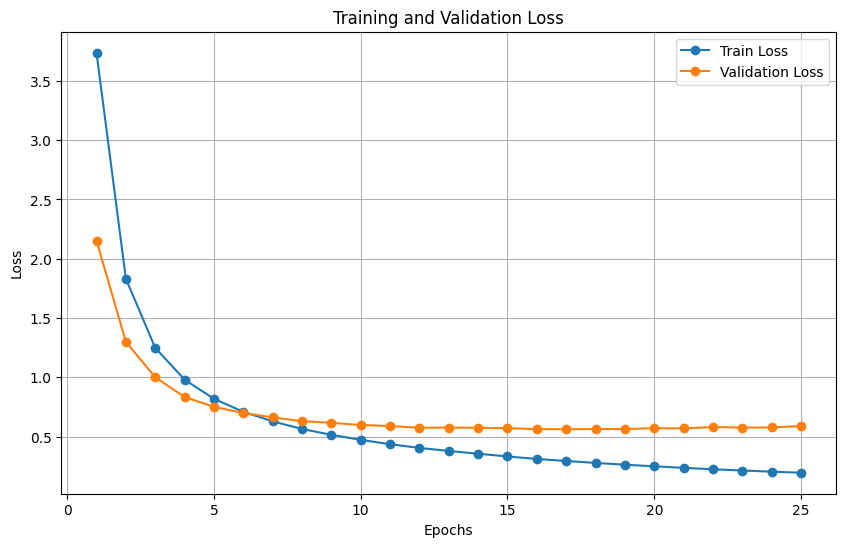

In [60]:
import matplotlib.pyplot as plt

def plot_loss(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, marker='o', label='Train Loss')
    plt.plot(epochs, val_losses, marker='o', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(train_losses, valid_losses)

In [71]:
eval_model = Transformer(len(SRC.vocab), len(TRG.vocab), opt['d_model'], opt['n_layers'], opt['heads'], opt['dropout'])

load_model(eval_model)
eval_model.to(opt['device'])

/tmp/ipykernel_23/1585372437.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Model loaded from bestmodel.pt!


Transformer(
  (encoder): Encoder(
    (embed): Embedder(
      (embed): Embedding(18700, 512)
    )
    (pe): PositionalEncoder(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (norm_1): Norm()
        (norm_2): Norm()
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=512, out_features=512, bias=True)
          (k_linear): Linear(in_features=512, out_features=512, bias=True)
          (v_linear): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (ff): FeedForward(
          (linear_1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear_2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout_1): Dropout(p=0.1, inplace=False)
        (dropout_2): Dropou

In [72]:
sentence='My family was not poor , and myself , I had never experienced hunger .'
trans_sent = translate_sentence(sentence, eval_model, SRC, TRG, opt['device'], opt['k'], opt['max_strlen'])
trans_sent

'gia_đình tôi không nghèo, và tôi chưa bao_giờ trải qua cơn đói.'

In [73]:
sentence='Sometime, I do not feel so good'
trans_sent = translate_sentence(sentence, eval_model, SRC, TRG, opt['device'], opt['k'], opt['max_strlen'])
trans_sent

'đôi_khi, tôi không cảm_thấy tốt'

In [74]:
sentences = ['I enjoy spending time outdoors, especially when the weather is nice.',
            'The sound of rain hitting the roof is very soothing to me.',
            'Whenever I feel stressed, I like to take a long walk in the park.',
            'The smell of fresh-baked cookies always reminds me of my childhood.']

for sentence in sentences:
    trans_sent = translate_sentence(sentence, eval_model, SRC, TRG, opt['device'], opt['k'], opt['max_strlen'])
    print(trans_sent)

tôi thích dành thời_gian ngoài_trời, đặc_biệt là thời_tiết đẹp.
tiếng mưa của mưa đâm mái nhà rất đối_với tôi.
bất_cứ khi nào tôi cảm_thấy căng_thẳng, tôi muốn đi dạo trong công_viên.
mùi bánh_quy tươi luôn làm tôi nhớ về thời thơ_ấu của mình.


In [75]:
sentences = ['she sells seashell on the seashore']

for sentence in sentences:
    trans_sent = translate_sentence(sentence, eval_model, SRC, TRG, opt['device'], opt['k'], opt['max_strlen'])
    print(trans_sent)

cô bán vỏ dự_phòng trên bờ biển


In [33]:
def bleu(valid_src_data, valid_trg_data, model, SRC, TRG, device, k, max_strlen):
    pred_sents = []
    for sentence in tqdm(valid_src_data):
        pred_trg = translate_sentence(sentence, model, SRC, TRG, device, k, max_strlen)
        pred_sents.append(pred_trg)

    pred_sents = [TRG.preprocess(sent) for sent in pred_sents]
    trg_sents = [[sent.split()] for sent in valid_trg_data]

    return bleu_score(pred_sents, trg_sents)

In [78]:
bleu(valid_src_data, valid_trg_data, eval_model, SRC, TRG, opt['device'], opt['k'], opt['max_strlen'])

/tmp/ipykernel_23/1025466030.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sentence in tqdm(valid_src_data):


  0%|          | 0/25409 [00:00<?, ?it/s]

0.3403435176258633